# Deep Learning From Scratch: Theory and Implementation

In this text, we develop the mathematical and algorithmic underpinnings of deep neural networks from scratch and implement our own neural network library in Python, mimicking the <a href="http://www.tensorflow.org">TensorFlow</a> API. I do not assume that you have any preknowledge about machine learning or neural networks. However, you should have some preknowledge of calculus, linear algebra, fundamental algorithms and probability theory on an undergraduate level. If you get stuck at some point, please leave a comment.

By the end of this text, you will have a deep understanding of the math behind neural networks and how deep learning libraries work under the hood.

I have tried to keep the code as simple and concise as possible, favoring conceptual clarity over efficiency. Since our API mimicks the TensorFlow API, you will know how to use TensorFlow once you have finished this text, and you will know how TensorFlow works under the hood conceptually (without all the overhead that comes with an omnipotent, maximally efficient machine learning API).

# Computational graphs
We shall start by defining the concept of a computational graph, since neural networks are a special form thereof. A computational graph is a directed graph where the nodes correspond to **operations** or **variables**. Variables can feed their value into operations, and operations can feed their output into other operations. This way, every node in the graph defines a function of the variables.

The values that are fed into the nodes and come out of the nodes are called <b>tensors</b>, which is just a fancy word for a multi-dimensional array. Hence, it subsumes scalars, vectors and matrices as well as tensors of a higher rank.

Let's look at an example. The following computational graph computes the sum $z$ of two inputs $x$ and $y$. 
Here, $x$ and $y$ are input nodes to $z$ and $z$ is a consumer of $x$ and $y$. $z$ therefore defines a function $z : \mathbb{R^2} \rightarrow \mathbb{R}$ where $z(x, y) = x + y$.

<img src="https://github.com/johnsl01/WebBits/blob/master/Tensorflow/addition.png?456&raw=1" style="height: 200px;">

The concept of a computational graph becomes more useful once the computations become more complex. For example, the following computational graph defines an affine transformation $z(A, x, b) = Ax + b$.

<img src="https://github.com/johnsl01/WebBits/blob/master/Tensorflow/affine_transformation.png?raw=1" style="height: 200px;">

## Operations

Every operation is characterized by three things:
- A `compute` function that computes the operation's output given values for the operation's inputs
- A list of `input_nodes` which can be variables or other operations
- A list of `consumers` that use the operation's output as their input

Let's put this into code:

In [0]:
class Operation:
    """Represents a graph node that performs a computation.
    
    An `Operation` is a node in a `Graph` that takes zero or
    more objects as input, and produces zero or more objects
    as output.
    """
    
    def __init__(self, input_nodes = []):
        """Construct Operation
        """
        self.input_nodes = input_nodes
        
        # Initialize list of consumers (i.e. nodes that receive this operation's output as input)
        self.consumers = []
        
        # Append this operation to the list of consumers of all input nodes
        for input_node in input_nodes:
            input_node.consumers.append(self)
        
        # Append this operation to the list of operations in the currently active default graph
        _default_graph.operations.append(self)
  
    def compute(self):
        """Computes the output of this operation.
        "" Must be implemented by the particular operation.
        """
        pass

### Some elementary operations

Let's implement some elementary operations in order to become familiar with the `Operation` class (and because we will need them later).

#### Addition

In [0]:
class add(Operation):
    """Returns x + y element-wise.
    """
    
    def __init__(self, x, y):
        """Construct add
        
        Args:
          x: First summand node
          y: Second summand node
        """
        super().__init__([x, y])

    def compute(self, x_value, y_value):
        """Compute the output of the add operation
        
        Args:
          x_value: First summand value
          y_value: Second summand value
        """
        self.inputs = [x_value, y_value]
        return x_value + y_value

#### Matrix multiplication

In [0]:
class matmul(Operation):
    """Multiplies matrix a by matrix b, producing a * b.
    """
    
    def __init__(self, a, b):
        """Construct matmul
        
        Args:
          a: First matrix
          b: Second matrix
        """
        super().__init__([a, b])
    
    def compute(self, a_value, b_value):
        """Compute the output of the matmul operation
        
        Args:
          a_value: First matrix value
          b_value: Second matrix value
        """
        self.inputs = [a_value, b_value]
        return a_value.dot(b_value)

## Placeholders

Not all the nodes in a computational graph are operations. For example, in the affine transformation graph, $A$, $x$ and $b$ are not operations. Rather, they are inputs to the graph that have to be supplied with a value once we want to compute the output of the graph. To provide such values, we introduce **placeholders**.

In [0]:
class placeholder:
    """Represents a placeholder node that has to be provided with a value
       when computing the output of a computational graph
    """
    def __init__(self):
        """Construct placeholder
        """
        self.consumers = []
        
        # Append this placeholder to the list of placeholders in the currently active default graph
        _default_graph.placeholders.append(self)

## Variables

In the affine transformation graph, there is a qualitative difference between $x$ on the one hand and $A$ and $b$ on the other hand. While $x$ is an input to the operation, $A$ and $b$ are <b>parameters</b> of the operation, i.e. they are intrinsic to the graph. We will refer to such parameters as <b>Variables</b>.

In [0]:
class Variable:
    """Represents a variable (i.e. an intrinsic, changeable parameter of a computational graph).
    """
    
    def __init__(self, initial_value = None):
        """Construct Variable
        
        Args:
          initial_value: The initial value of this variable
        """
        self.value = initial_value
        self.consumers = []
        
        # Append this variable to the list of variables in the currently active default graph
        _default_graph.variables.append(self)

## The Graph class

Finally, we'll need a class that bundles all the operations, placeholders and variables together. When creating a new graph, we can call its `as_default` method to set the `_default_graph` to this graph. This way, we can create operations, placeholders and variables without having to pass in a reference to the graph everytime.

In [0]:
class Graph:
    """Represents a computational graph
    """
    
    def __init__(self):
        """Construct Graph"""
        self.operations = []
        self.placeholders = []
        self.variables = []
        
    def as_default(self):
        global _default_graph
        _default_graph = self

## Example

Let's now use the classes we have built to create a computational graph for the following affine transformation:

$$
z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
\cdot
x
+
\begin{pmatrix}
1 \\
1
\end{pmatrix}
$$

In [0]:
# Create a new graph
Graph().as_default()

# Create variables
A = Variable([[1, 0], [0, -1]])
b = Variable([1, 1])

# Create placeholder
x = placeholder()

# Create hidden node y
y = matmul(A, x)

# Create output node z
z = add(y, b)

## Computing the output of an operation
Now that we are confident creating computational graphs, we can start to think about how to compute the output of an operation.

Let's create a Session class that encapsulates an execution of an operation. We would like to be able to create a session instance and call a `run` method on this instance, passing the operation that we want to compute and a dictionary containing values for the placeholders:

    session = Session()
    output = session.run(z, {
        x: [1, 2]
    })

This should compute the following value:

$$
z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
\cdot
\begin{pmatrix}
1 \\
2
\end{pmatrix}
+
\begin{pmatrix}
1 \\
1
\end{pmatrix}
=
\begin{pmatrix}
2 \\
-1
\end{pmatrix}
$$

In order to compute the function represented by an operation, we need to apply the computations in the right order. For example, we cannot compute $z$ before we have computed $y$ as an intermediate result. Therefore, we have to make sure that the operations are carried out in the right order, such that the values of every node that is an input to an operation $o$ has been computed before $o$ is computed. This can be achieved via <a href="https://en.wikipedia.org/wiki/Tree_traversal#Post-order" target="new">post-order traversal</a>.


In [0]:
import numpy as np

class Session:
    """Represents a particular execution of a computational graph.
    """
    
    def run(self, operation, feed_dict = {}):
        """Computes the output of an operation
        
        Args:
          operation: The operation whose output we'd like to compute.
          feed_dict: A dictionary that maps placeholders to values for this session
        """
        
        # Perform a post-order traversal of the graph to bring the nodes into the right order
        nodes_postorder = traverse_postorder(operation)
        
        # Iterate all nodes to determine their value
        for node in nodes_postorder:

            if type(node) == placeholder:
                # Set the node value to the placeholder value from feed_dict
                node.output = feed_dict[node]
            elif type(node) == Variable:
                # Set the node value to the variable's value attribute
                node.output = node.value
            else: # Operation
                # Get the input values for this operation from node_values
                node.inputs = [input_node.output for input_node in node.input_nodes]

                # Compute the output of this operation
                node.output = node.compute(*node.inputs)
                
            # Convert lists to numpy arrays
            if type(node.output) == list:
                node.output = np.array(node.output)
        
        # Return the requested node value
        return operation.output


def traverse_postorder(operation):
    """Performs a post-order traversal, returning a list of nodes
    in the order in which they have to be computed
    
    Args:
       operation: The operation to start traversal at
    """
    
    nodes_postorder = []
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)

    recurse(operation)
    return nodes_postorder

Let's test our class on the example from above:

In [287]:
session = Session()
output = session.run(z, {
    x: [1, 2]
})
print(output)

[ 2 -1]


Looks good.

# Perceptrons

## A motivating example

Perceptrons are a miniature form of neural network and a basic building block of more complex architectures. Before going into the details, let's motivate them by an example. Assume that we are given a dataset consisting of 100 points in the plane. Half of the points are red and half of the points are blue.

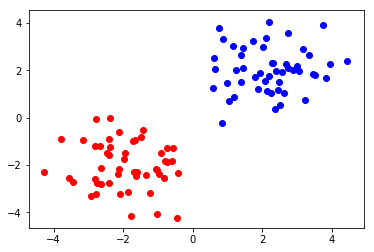

In [288]:
import matplotlib.pyplot as plt

# Create red points centered at (-2, -2)
red_points = np.random.randn(50, 2) - 2*np.ones((50, 2))

# Create blue points centered at (2, 2)
blue_points = np.random.randn(50, 2) + 2*np.ones((50, 2))

# Plot them
plt.scatter(red_points[:,0], red_points[:,1], color='red')
plt.scatter(blue_points[:,0], blue_points[:,1], color='blue')
plt.show()

As we can see, the red points are centered at $(-2, -2)$ and the blue points are centered at $(2, 2)$. Now, having seen this data, we can ask ourselves whether there is a way to determine if a point should be red or blue. For example, if someone asks us what the color of the point $(3, 2)$ should be, we'd best respond with blue. Even though this point was not part of the data we have seen, we can infer this since it is located in the blue region of the space.

But what is the general rule to determine if a point is more likely to be blue than red? Apparently, we can draw a line $y = -x$ that nicely separates the space into a red region and a blue region:

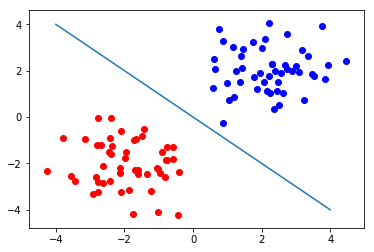

In [289]:
# Plot a line y = -x
x_axis = np.linspace(-4, 4, 100)
y_axis = -x_axis
plt.plot(x_axis, y_axis)

# Add the red and blue points
plt.scatter(red_points[:,0], red_points[:,1], color='red')
plt.scatter(blue_points[:,0], blue_points[:,1], color='blue')
plt.show()

We can implicitly represent this line using a <b>weight vector</b> $w$ and a <b>bias</b> $b$. The line then corresponds to the set of points $x$ where

$$w^T x + b = 0.$$

In the case above, we have $w = (1, 1)^T$ and $b = 0$. Now, in order to test whether the point is blue or red, we just have to check whether it is above or below the line. This can be achieved by checking the sign of $w^T x + b$. If it is positive, then $x$ is above the line. If it is negative, then $x$ is below the line. Let's perform this test for our example point $(3, 2)^T$:

$$
\begin{pmatrix}
1 & 1
\end{pmatrix}
\cdot \begin{pmatrix}
3 \\
2
\end{pmatrix} = 5
$$

Since 5 > 0, we know that the point is above the line and, therefore, should be classified as blue.

## Perceptron definition

In general terms, a <b>classifier</b> is a function $\hat{c} : \mathbb{R}^d \rightarrow \{1, 2, ..., C\}$ that maps a point onto one of $C$ classes. A <b>binary classifier</b> is a classifier where $C = 2$, i.e. we have two classes. A <b>perceptron</b> with weight $w \in \mathbb{R}^d$ and bias $b \in \mathbb{R}^d$ is a binary classifier where

$$
  \hat{c}(x) = 
  \begin{cases}
    1, & \text{if } w^T x + b \geq 0 \\
    2, & \text{if } w^T x + b < 0
  \end{cases}
$$

$\hat{c}$ partitions $\mathbb{R}^d$ into two half-spaces, each corresponding to one of the two classes. In the 2-dimensional example above, the partitioning is along a line. In general, the partitioning is along a $d-1$ dimensional hyperplane.

## From classes to probabilities

Depending on the application, we may be interested not only in determining the most likely class of a point, but also the probability with which it belongs to that class. Note that the higher the value of $w^T x + b$, the higher is its distance to the separating line and, therefore, the higher is our confidence that it belongs to the blue class. But this value can be arbitrarily high. In order to turn this value into a probability, we need to "squash" the values to lie between 0 and 1. One way to do this is by applying the <b>sigmoid</b> function $\sigma$:

$$p(\hat{c}(x) = 1 \mid x) = \sigma(w^T x + b)$$ where $$\sigma(a) = \frac{1}{1 + e^{-a}}$$

Let's take a look at what the sigmoid function looks like:

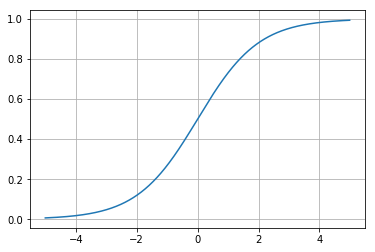

In [290]:
# Create an interval from -5 to 5 in steps of 0.01
a = np.arange(-5, 5, 0.01)

# Compute corresponding sigmoid function values
s = 1 / (1 + np.exp(-a))

# Plot them
plt.plot(a, s)
plt.grid(True)
plt.show()

As we can see, the sigmoid function assigns a probability of 0.5 to values where $w^T x + b = 0$ (i.e. points on the line) and asymptotes towards 1 the higher the value of $w^T x + b$ becomes, and towards 0 the lower it becomes, which is exactly what we want.

Let's now define the sigmoid function as an operation, since we'll need it later:

In [0]:
class sigmoid(Operation):
    """Returns the sigmoid of x element-wise.
    """
    
    def __init__(self, a):
        """Construct sigmoid
        
        Args:
          a: Input node
        """
        super().__init__([a])

    def compute(self, a_value):
        """Compute the output of the sigmoid operation
        
        Args:
          a_value: Input value
        """
        return 1 / (1 + np.exp(-a_value))

The entire computational graph of the perceptron now looks as follows:

<img src='https://github.com/johnsl01/WebBits/blob/master/Tensorflow/perceptron.png?1&raw=1' style='height: 150px;'>

### Example

Using what we have learned, we can now build a perceptron for the red/blue example in Python.

In [0]:
# Create a new graph
Graph().as_default()

x = placeholder()
w = Variable([1, 1])
b = Variable(0)
p = sigmoid( add(matmul(w, x), b) )

Let's use this perceptron to compute the probability that $(3, 2)^T$ is a blue point:

In [293]:
session = Session()
print(session.run(p, {
    x: [3, 2]
}))

0.9933071490757153


## Multi-class perceptron

So far, we have used the perceptron as a binary classifier, telling us the probability $p$ that a point $x$ belongs to one of two classes. The probability of $x$ belonging to the respective other class is then given by $1-p$. Generally, however, we have more than two classes. For example, when classifying an image, there may be numerous output classes (dog, chair, human, house, ...). We can extend the perceptron to compute multiple output probabilities.

Let $C$ denote the number of output classes. Instead of a weight vector $w$, we introduce a weight matrix $W \in \mathbb{R}^{d \times C}$. Each column of the weight matrix contains the weights of a separate linear classifier - one for each class. Instead of the dot product $w^T x$, we compute $x \, W$, which returns a vector in $\mathbb{R}^C$, each of whose entries can be seen as the output of the dot product for a different column of the weight matrix. To this, we add a bias vector $b \in \mathbb{R}^m$, containing a distinct bias for each output class. This then yields a vector in $\mathbb{R}^C$ containing the probabilities for each of the $C$ classes.

While this procedure may seem complicated, the matrix multiplication actually just performs multiple linear classifications in parallel, one for each of the $C$ classes - each one with its own separating line, given by a weight vector (one column of $W$) and a bias (one entry of $b$).

<img src='https://github.com/johnsl01/WebBits/blob/master/Tensorflow/perceptron2.png?1&raw=1' style='height: 150px;'>

### Softmax

While the original perceptron yielded a single scalar value that we squashed through a sigmoid to obtain a probability between 0 and 1, the multi-class perceptron yields a vector $a \in \mathbb{R}^m$. The higher the i-th entry of $a$, the higher is our confidence that the input point belongs to the i-th class. We would like to turn $a$ into a vector of probabilities, such that the probability for every class lies between 0 and 1 and the probabilities for all classes sum up to 1.

A common way to do this is to use the <b>softmax function</b>, which is a generalization of the sigmoid to multiple output classes:

$$
\sigma(a)_i = \frac{e^{a_i}}{\sum_{j = 1}^C e^{a_j}}
$$

In [0]:
class softmax(Operation):
    """Returns the softmax of a.
    """
    
    def __init__(self, a):
        """Construct softmax
        
        Args:
          a: Input node
        """
        super().__init__([a])

    def compute(self, a_value):
        """Compute the output of the softmax operation
        
        Args:
          a_value: Input value
        """
        return np.exp(a_value) / np.sum(np.exp(a_value), axis = 1)[:,None]

### Batch computation

The matrix form allows us to feed in more than one point at a time. That is, instead of a single point $x$, we could feed in a matrix $X \in \mathbb{R}^{N \times d}$ containing one point per row (i.e. $N$ rows of $d$-dimensional points). We refer to such a matrix as a <b>batch</b>. Instead of $xW$, we compute $XW$. This returns an $N \times C$ matrix, each of whose rows contains $xW$ for one point $x$. To each row, we add a bias vector $b$, which is now an $1 \times m$ row vector. The whole procedure thus computes a function $f : \mathbb{R}^{N \times d} \rightarrow \mathbb{R}^{m}$ where $f(X) = \sigma(XW + b)$. The computational graph looks as follows:

<img src='https://github.com/johnsl01/WebBits/blob/master/Tensorflow/perceptron3.png?2&raw=1' style='height: 150px;'>

### Example

Let's now generalize our red/blue perceptron to allow for batch computation and multiple output classes.

In [0]:
# Create a new graph
Graph().as_default()

X = placeholder()

# Create a weight matrix for 2 output classes:
# One with a weight vector (1, 1) for blue and one with a weight vector (-1, -1) for red
W = Variable([
    [1, -1],
    [1, -1]
])
b = Variable([0, 0])
p = softmax( add(matmul(X, W), b) )

In [296]:
# Create a session and run the perceptron on our blue/red points
session = Session()
output_probabilities = session.run(p, {
    X: np.concatenate((blue_points, red_points))
})

# Print the first 10 lines, corresponding to the probabilities of the first 10 points
print(output_probabilities[:10])

[[9.99995834e-01 4.16605425e-06]
 [9.99316304e-01 6.83695908e-04]
 [9.84427603e-01 1.55723967e-02]
 [9.98486531e-01 1.51346904e-03]
 [9.99994044e-01 5.95576015e-06]
 [9.99643489e-01 3.56510944e-04]
 [9.99891228e-01 1.08771577e-04]
 [9.99935526e-01 6.44744593e-05]
 [9.99998883e-01 1.11696480e-06]
 [9.95734567e-01 4.26543274e-03]]


Since the first 10 points in our data are all blue, the perceptron outputs high probabilities for blue (left column) and low probabilities for red (right column), as expected.

# Training criterion

Great, so now we are able to classify points using a linear classifier and compute the probability that the point belongs to a certain class, provided that we know the appropriate parameters for the weight matrix $W$ and bias $b$. The natural question that arises is how to come up with appropriate values for these. In the red/blue example, we just looked at the training points and guessed a line that nicely separated the training points. But generally we do not want to specify the separating line by hand. Rather, we just want to supply the training points to the computer and let it come up with a good separating line on its own. But how do we judge whether a separating line is good or bad?

## The misclassification rate

Ideally, we want to find a line that makes as few errors as possible. For every point $x$ and class $c(x)$ drawn from the true but unknown data-generating distribution $p_\text{data}(x, c(x))$, we want to minimize the probability that our perceptron classifies it incorrectly - the <b>probability of misclassification</b>:

$$\underset{W, b}{\operatorname{argmin}} p(\hat{c}(x) \neq c(x) \mid x, c(x) \, \tilde{} \, p_\text{data} )$$

Generally, we do not know the data-generating distribution $p_\text{data}$, so it is impossible to compute the exact probability of misclassification. Instead, we are given a finite list of $N$ <b>training points</b> consisting of the values of $x$ with their corresponding classes. In the following, we represent the list of training points as a matrix $X \in \mathbb{R}^{N \times d}$ where each row corresponds to one training point and each column to one dimension of the input space. Moreover, we represent the true classes as a matrix $c \in \mathbb{R}^{N \times C}$ where $c_{i, j} = 1$ if the $i$-th training sample has class $j$. Similarly, we represent the predicted classes as a matrix $\hat{c} \in \mathbb{R}^{N \times C}$ where $\hat{c}_{i, j} = 1$ if the $i$-th training sample has a predicted class $j$. Finally, we represent the output probabilities of our model as a matrix $p \in \mathbb{R}^{N \times C}$ where $p_{i, j}$ contains the probability that the $i$-th training sample belongs to the j-th class.

We could use the training data to find a classifier that minimizes the <b>misclassification rate</b> on the training samples:

$$
\underset{W, b}{\operatorname{argmin}} \frac{1}{N} \sum_{i = 1}^N I(\hat{c}_i \neq c_i)
$$

However, it turns out that finding a linear classifier that minimizes the misclassification rate is an intractable problem, i.e. its computational complexity is exponential in the number of input dimensions, rendering it unpractical. Moreover, even if we have found a classifier that minimizes the misclassification rate on the training samples, it might be possible to make the classifier more robust to unseen samples by pushing the classes further apart, even if this does not reduce the misclassification rate on the training samples.

## Maximum likelihood estimation

An alternative is to use <a href="https://en.wikipedia.org/wiki/Maximum_likelihood_estimation">maximum likelihood estimation</a>, where we try to find the parameters that maximize the probability of the training data:

<div class="left_equation" style="margin-top: 20px; padding-left: 50px;">
\begin{align}
 \underset{W, b}{\operatorname{argmax}} p(\hat{c} = c) \\
\end{align}

\begin{align}
= \underset{W, b}{\operatorname{argmax}} \prod_{i=1}^N p(\hat{c}_i = c_i) \\
\end{align}

\begin{align}
= \underset{W, b}{\operatorname{argmax}} \prod_{i=1}^N \prod_{j=1}^C  p_{i, j}^{I(c_i = j)} \\
\end{align}

\begin{align}
= \underset{W, b}{\operatorname{argmax}} \prod_{i=1}^N \prod_{j=1}^C  p_{i, j}^{c_{i, j}} \\
\end{align}

\begin{align}
= \underset{W, b}{\operatorname{argmax}} log \prod_{i=1}^N \prod_{j=1}^C  p_{i, j}^{c_{i, j}} \\
\end{align}

\begin{align}
= \underset{W, b}{\operatorname{argmax}} \sum_{i=1}^N \sum_{j=1}^C c_{i, j} \cdot log \, p_{i, j} \\
\end{align}

\begin{align}
= \underset{W, b}{\operatorname{argmin}} - \sum_{i=1}^N \sum_{j=1}^C c_{i, j} \cdot log \, p_{i, j} \\
\end{align}


\begin{align}
= \underset{W, b}{\operatorname{argmin}} J
\end{align}

</div>

We refer to $J = - \sum_{i=1}^N \sum_{j=1}^C c_{i, j} \cdot log \, p_{i, j}$ as the <b>cross-entropy loss</b>. We want to minimize $J$.

We can view $J$ as yet another operation in our computational graph that takes the input data $X$, the true classes $c$ and our predicted probabilities $p$ (which are the output of the $\sigma$ operation) as input and computes a real number designating the loss:

<img src="https://github.com/johnsl01/WebBits/blob/master/Tensorflow/loss_graph.png?raw=1" style="height: 200px;">

## Building an operation that computes $J$

We can build up $J$ from various more primitive operations. Using the element-wise matrix multiplication $\odot$, we can rewrite $J$ as follows:

$$
- \sum_{i=1}^N \sum_{j=1}^C (c \odot log \, p)_{i, j}
$$

Going from the inside out, we can see that we need to implement the following operations:
- $log$: The element-wise logarithm of a matrix or vector
- $\odot$: The element-wise product of two matrices
- $\sum_{j=1}^C$: Sum over the columns of a matrix
- $\sum_{i=1}^N$: Sum over the rows of a matrix
- $-$: Taking the negative

Let's implement these operations.

### log
This computes the element-wise logarithm of a tensor.

In [0]:
class log(Operation):
    """Computes the natural logarithm of x element-wise.
    """
    
    def __init__(self, x):
        """Construct log
        
        Args:
          x: Input node
        """
        super().__init__([x])

    def compute(self, x_value):
        """Compute the output of the log operation
        
        Args:
          x_value: Input value
        """
        return np.log(x_value)

### multiply / $\odot$
This computes the element-wise product of two tensors of the same shape.

In [0]:
class multiply(Operation):
    """Returns x * y element-wise.
    """
    
    def __init__(self, x, y):
        """Construct multiply
        
        Args:
          x: First multiplicand node
          y: Second multiplicand node
        """
        super().__init__([x, y])

    def compute(self, x_value, y_value):
        """Compute the output of the multiply operation
        
        Args:
          x_value: First multiplicand value
          y_value: Second multiplicand value
        """
        return x_value * y_value

### reduce_sum

We'll implement the summation over rows, columns, etc. in a single operation where we specify an `axis`. This way, we can use the same method for all types of summations. For example, `axis = 0` sums over the rows, `axis = 1` sums over the columns, etc. This is exactly what `numpy.sum` does.

In [0]:
class reduce_sum(Operation):
    """Computes the sum of elements across dimensions of a tensor.
    """
    
    def __init__(self, A, axis = None):
        """Construct reduce_sum
        
        Args:
          A: The tensor to reduce.
          axis: The dimensions to reduce. If `None` (the default), reduces all dimensions.
        """
        super().__init__([A])
        self.axis = axis

    def compute(self, A_value):
        """Compute the output of the reduce_sum operation
        
        Args:
          A_value: Input tensor value
        """
        return np.sum(A_value, self.axis)

### negative

This computes the element-wise negative of a tensor.

In [0]:
class negative(Operation):
    """Computes the negative of x element-wise.
    """
    
    def __init__(self, x):
        """Construct negative
        
        Args:
          x: Input node
        """
        super().__init__([x])

    def compute(self, x_value):
        """Compute the output of the negative operation
        
        Args:
          x_value: Input value
        """
        return -x_value

### Putting it all together
Using these operations, we can now compute $J = - \sum_{i=1}^N \sum_{j=1}^C (c \odot log \, p)_{i, j}
$ as follows:

    J = negative(reduce_sum(reduce_sum(multiply(c, log(p)), axis=1)))


### Example

Let's now compute the loss of our red/blue perceptron.

In [301]:
# Create a new graph
Graph().as_default()

X = placeholder()
c = placeholder()

W = Variable([
    [1, -1],
    [1, -1]
])
b = Variable([0, 0])
p = softmax( add(matmul(X, W), b) )

# Cross-entropy loss
J = negative(reduce_sum(reduce_sum(multiply(c, log(p)), axis=1)))

session = Session()
print(session.run(J, {
    X: np.concatenate((blue_points, red_points)),
    c:
        [[1, 0]] * len(blue_points)
        + [[0, 1]] * len(red_points)
    
}))

0.5022408336701938


# Gradient descent

Generally, if we want to find the minimum of a function, we set the derivative to zero and solve for the parameters. It turns out, however, that it is impossible to obtain a closed-form solution for $W$ and $b$. Instead, we iteratively search for a minimum using a method called <b>gradient descent</b>.

As a visual analogy, imagine yourself standing on a mountain and trying to find the way down. At every step, you walk into the steepest direction, since this direction is the most promising to lead you towards the bottom.

<img src="https://github.com/johnsl01/WebBits/blob/master/Tensorflow/gradient_descent.png?raw=1" style="width: 400px;">

If taking steep steps seems a little dangerous to you, imagine that you are a mountain goat (which are <a href="https://www.youtube.com/watch?v=hZWxlxrIWus">amazing rock climbers</a>).

Gradient descent operates in a similar way when trying to find the minimum of a function: It starts at a random location in parameter space and then iteratively reduces the error $J$ until it reaches a local minimum. At each step of the iteration, it determines the direction of steepest descent and takes a step along that direction. This process is depicted for the 1-dimensional case in the following image.

<img src="https://github.com/johnsl01/WebBits/blob/master/Tensorflow/gradient_descent_2.png?123&raw=1" style="width: 400px;">

As you might remember, the direction of steepest ascent of a function at a certain point is given by the gradient at that point. Therefore, the direction of steepest descent is given by the negative of the gradient. So now we have a rough idea how to minimize $J$:
1. Start with random values for $W$ and $b$
2. Compute the gradients of $J$ with respect to $W$ and $b$
3. Take a small step along the direction of the negative gradient
4. Go back to 2

Let's implement an operation that minimizes the value of a node using gradient descent. We require the user to specify the magnitude of the step along the gradient as a parameter called `learning_rate`.

In [0]:
from queue import Queue

class GradientDescentOptimizer:
    
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def minimize(self, loss):
        learning_rate = self.learning_rate
        class MinimizationOperation(Operation):
            def compute(self):
                # Compute gradients
                grad_table = compute_gradients(loss)
                
                # Iterate all variables
                for node in grad_table:
                    if type(node) == Variable:
                        # Retrieve gradient for this variable
                        grad = grad_table[node]
                                                
                        # Take a step along the direction of the negative gradient
                        node.value -= learning_rate * grad
                
                
        return MinimizationOperation()

The following image depicts an example iteration of gradient descent. We start out with a random separating line (marked as 1), take a step, arrive at a slightly better line (marked as 2), take another step, and another step, and so on until we arrive at a good separating line.

<img src="https://github.com/johnsl01/WebBits/blob/master/Tensorflow/gradient_descent_3.png?raw=1" style="height: 250px;">

# Backpropagation

In our implementation of gradient descent, we have used a function `compute_gradient(loss)` that computes the gradient of a $loss$ operation in our computational graph with respect to the output of every other node $n$ (i.e. the direction of change for $n$ along which the loss increases the most). We now need to figure out how to compute gradients.

Consider the following computational graph:

<img src="https://github.com/johnsl01/WebBits/blob/master/Tensorflow/abcde.png?raw=1" style="height: 70px;">

By the <a href="https://en.wikipedia.org/wiki/Chain_rule">chain rule</a>, we have

$$\frac{\partial e}{\partial a} = \frac{\partial e}{\partial b} \cdot \frac{\partial b}{\partial a} = \frac{\partial e}{\partial c} \cdot \frac{\partial c}{\partial b} \cdot \frac{\partial b}{\partial a} = \frac{\partial e}{\partial d} \cdot \frac{\partial d}{\partial c} \cdot \frac{\partial c}{\partial b} \cdot \frac{\partial b}{\partial a}$$

As we can see, in order to compute the gradient of $e$ with respect to $a$, we can start at $e$ an go backwards towards $a$, computing the gradient of every node's output with respect to its input along the way until we reach $a$. Then, we multiply them all together.

Now consider the following scenario:

<img src="https://github.com/johnsl01/WebBits/blob/master/Tensorflow/abcde2.png?raw=1" style="height: 160px;">

In this case, $a$ contributes to $e$ along two paths: The path $a$, $b$, $d$, $e$ and the path $a$, $b$, $c$, $e$. Hence, the <a href="https://en.wikipedia.org/wiki/Total_derivative">total derivative</a> of $e$ with respect to $a$ is given by:

$$
\frac{\partial e}{\partial a}
= \frac{\partial e}{\partial d} \cdot \frac{\partial d}{\partial a}
= \frac{\partial e}{\partial d} \cdot \left( \frac{\partial d}{\partial b} \cdot \frac{\partial b}{\partial a} + \frac{\partial d}{\partial c} \cdot \frac{\partial c}{\partial a} \right)
= \frac{\partial e}{\partial d} \cdot \frac{\partial d}{\partial b} \cdot \frac{\partial b}{\partial a} + \frac{\partial e}{\partial d} \cdot \frac{\partial d}{\partial c} \cdot \frac{\partial c}{\partial a}
$$

This gives as an intuition for the general algorithm that computes the gradient of the loss with respect to another node: We perform a backwards <a href="https://en.wikipedia.org/wiki/Breadth-first_search">breadth-first search</a> starting from the loss node. At each node $n$ that we visit, we do the following for each of its consumers:
- retrieve the gradient $G$ of the loss with respect to the output of the consumer
- multiply $G$ by the gradient of the consumer's output with respect to $n$'s output

And then we sum those gradients over all consumers.

As a prerequisite to implementing backpropagation, we need to specify a function for each operation that computes the gradients with respect to the inputs of that operation, given the gradients with respect to the output. Let's define a decorator `@RegisterGradient(operation_name)` for this purpose:

In [0]:
# A dictionary that will map operations to gradient functions
_gradient_registry = {}
            
class RegisterGradient:
    """A decorator for registering the gradient function for an op type.
    """

    def __init__(self, op_type):
        """Creates a new decorator with `op_type` as the Operation type.
        Args:
          op_type: The name of an operation
        """
        self._op_type = eval(op_type)

    def __call__(self, f):
        """Registers the function `f` as gradient function for `op_type`."""
        _gradient_registry[self._op_type] = f
        return f

Now assume that our `_gradient_registry` dictionary is already filled with gradient computation functions for all of our operations. We can now implement backpropagation:

In [0]:
from queue import Queue

def compute_gradients(loss):

    # grad_table[node] will contain the gradient of the loss w.r.t. the node's output
    grad_table = {}

    # The gradient of the loss with respect to the loss is just 1
    grad_table[loss] = 1

    # Perform a breadth-first search, backwards from the loss
    visited = set()
    queue = Queue()
    visited.add(loss)
    queue.put(loss)

    while not queue.empty():
        node = queue.get()

        # If this node is not the loss
        if node != loss:
            #
            # Compute the gradient of the loss with respect to this node's output
            #
            grad_table[node] = 0

            # Iterate all consumers
            for consumer in node.consumers:

                # Retrieve the gradient of the loss w.r.t. consumer's output
                lossgrad_wrt_consumer_output = grad_table[consumer]

                # Retrieve the function which computes gradients with respect to
                # consumer's inputs given gradients with respect to consumer's output.
                consumer_op_type = consumer.__class__
                bprop = _gradient_registry[consumer_op_type]

                # Get the gradient of the loss with respect to all of consumer's inputs
                lossgrads_wrt_consumer_inputs = bprop(consumer, lossgrad_wrt_consumer_output)
                
                if len(consumer.input_nodes) == 1:
                    # If there is a single input node to the consumer, lossgrads_wrt_consumer_inputs is a scalar
                    grad_table[node] += lossgrads_wrt_consumer_inputs
                    
                else:
                    # Otherwise, lossgrads_wrt_consumer_inputs is an array of gradients for each input node
                
                    # Retrieve the index of node in consumer's inputs
                    node_index_in_consumer_inputs = consumer.input_nodes.index(node)

                    # Get the gradient of the loss with respect to node
                    lossgrad_wrt_node = lossgrads_wrt_consumer_inputs[node_index_in_consumer_inputs]

                    # Add to total gradient
                    grad_table[node] += lossgrad_wrt_node

        #
        # Append each input node to the queue
        #
        if hasattr(node, "input_nodes"):
            for input_node in node.input_nodes:
                if not input_node in visited:
                    visited.add(input_node)
                    queue.put(input_node)
            
    # Return gradients for each visited node
    return grad_table

## Gradient of each operation

For each of our operations, we now need to define a function that turns a gradient of the loss with respect to the operation's output into a list of gradients of the loss with respect to each of the operation's inputs. Computing a gradient with respect to a matrix can be somewhat tedious. Therefore, the details have been omitted and I just present the results. You may skip this section and still understand the overall picture.

If you want to comprehend how to arrive at the results, the general approach is as follows:
- Find the partial derivative of each output value with respect to each input value (this can be a tensor of a rank greater than 2, i.e. neither scalar nor vector nor matrix, involving a lot of summations)
- Compute the gradient of the loss with respect to the node's inputs given a gradient with respect to the node's output by applying the chain rule. This is now a tensor of the same shape as the input tensor, so if the input is a matrix, the result is also a matrix
- Rewrite this result as a sequence of matrix operations in order to compute it efficiently. This step can be somewhat tricky.

### Gradient for `add`
Given a gradient $G$ with respect to $a + b$, the gradient with respect to $a$ is given by $G$ and the gradient with respect to $b$ is also given by $G$, provided that $a$ and $b$ are of the same shape. If $a$ and $b$ are of different shapes, e.g. one matrix $a$ with 100 rows and one row vector $b$, we assume that $b$ is added to each row of $a$. In this case, the gradient computation is a little more involved, but I will not spell out the details here.

In [0]:
@RegisterGradient("add")
def _add_gradient(op, grad):
    """Computes the gradients for `add`.

    Args:
      op: The `add` `Operation` that we are differentiating
      grad: Gradient with respect to the output of the `add` op.

    Returns:
      Gradients with respect to the input of `add`.
    """
    a = op.inputs[0]
    b = op.inputs[1]
    
    grad_wrt_a = grad
    while np.ndim(grad_wrt_a) > len(a.shape):
        grad_wrt_a = np.sum(grad_wrt_a, axis=0)
    for axis, size in enumerate(a.shape):
        if size == 1:
            grad_wrt_a = np.sum(grad_wrt_a, axis=axis, keepdims=True)
    
    grad_wrt_b = grad
    while np.ndim(grad_wrt_b) > len(b.shape):
        grad_wrt_b = np.sum(grad_wrt_b, axis=0)
    for axis, size in enumerate(b.shape):
        if size == 1:
            grad_wrt_b = np.sum(grad_wrt_b, axis=axis, keepdims=True)
    
    return [grad_wrt_a, grad_wrt_b]

### Gradient for `matmul`

Given a gradient $G$ with respect to $AB$, the gradient with respect to $A$ is given by $GB^T$ and the gradient with respect to $B$ is given by $A^TG$.

In [0]:
@RegisterGradient("matmul")
def _matmul_gradient(op, grad):
    """Computes the gradients for `matmul`.

    Args:
      op: The `matmul` `Operation` that we are differentiating
      grad: Gradient with respect to the output of the `matmul` op.

    Returns:
      Gradients with respect to the input of `matmul`.
    """

    A = op.inputs[0]
    B = op.inputs[1]

    return [grad.dot(B.T), A.T.dot(grad)]

### Gradient for `sigmoid`

Given a gradient $G$ with respect to $\sigma(a)$, the gradient with respect to $a$ is given by $G \cdot \sigma(a) \cdot \sigma(1-a)$.

In [0]:
@RegisterGradient("sigmoid")
def _sigmoid_gradient(op, grad):
    """Computes the gradients for `sigmoid`.

    Args:
      op: The `sigmoid` `Operation` that we are differentiating
      grad: Gradient with respect to the output of the `sigmoid` op.

    Returns:
      Gradients with respect to the input of `sigmoid`.
    """
    
    sigmoid = op.output

    return grad * sigmoid * (1-sigmoid)

### Gradient for `softmax`


In [0]:
@RegisterGradient("softmax")
def _softmax_gradient(op, grad):
    """Computes the gradients for `softmax`.

    Args:
      op: The `softmax` `Operation` that we are differentiating
      grad: Gradient with respect to the output of the `softmax` op.

    Returns:
      Gradients with respect to the input of `softmax`.
    """
    
    softmax = op.output
    return (grad - np.reshape(
        np.sum(grad * softmax, 1),
        [-1, 1]
    )) * softmax

### Gradient for `log`

Given a gradient $G$ with respect to $log(x)$, the gradient with respect to $x$ is given by $\frac{G}{x}$.

In [0]:
@RegisterGradient("log")
def _log_gradient(op, grad):
    """Computes the gradients for `log`.

    Args:
      op: The `log` `Operation` that we are differentiating
      grad: Gradient with respect to the output of the `log` op.

    Returns:
      Gradients with respect to the input of `log`.
    """
    x = op.inputs[0]
    return grad/x

### Gradient for `multiply`

Given a gradient $G$ with respect to $A \odot B$, the gradient with respect to $A$ is given by $G \odot B$ and the gradient with respect to $B$ is given by $G \odot A$.

In [0]:
@RegisterGradient("multiply")
def _multiply_gradient(op, grad):
    """Computes the gradients for `multiply`.

    Args:
      op: The `multiply` `Operation` that we are differentiating
      grad: Gradient with respect to the output of the `multiply` op.

    Returns:
      Gradients with respect to the input of `multiply`.
    """

    A = op.inputs[0]
    B = op.inputs[1]

    return [grad * B, grad * A]

### Gradient for `reduce_sum`

Given a gradient $G$ with respect to the output of `reduce_sum`, the gradient with respect to the input $A$ is given by repeating $G$ along the specified axis.

In [0]:
@RegisterGradient("reduce_sum")
def _reduce_sum_gradient(op, grad):
    """Computes the gradients for `reduce_sum`.

    Args:
      op: The `reduce_sum` `Operation` that we are differentiating
      grad: Gradient with respect to the output of the `reduce_sum` op.

    Returns:
      Gradients with respect to the input of `reduce_sum`.
    """
    A = op.inputs[0]

    output_shape = np.array(A.shape)
    output_shape[op.axis] = 1
    tile_scaling = A.shape // output_shape
    grad = np.reshape(grad, output_shape)
    return np.tile(grad, tile_scaling)

### Gradient for `negative`

Given a gradient $G$ with respect to $-x$, the gradient with respect to $x$ is given by $-G$.

In [0]:
@RegisterGradient("negative")
def _negative_gradient(op, grad):
    """Computes the gradients for `negative`.

    Args:
      op: The `negative` `Operation` that we are differentiating
      grad: Gradient with respect to the output of the `negative` op.

    Returns:
      Gradients with respect to the input of `negative`.
    """
    return -grad

## Example

Let's now test our implementation to determine the optimal weights for our perceptron.

In [313]:
# Create a new graph
Graph().as_default()

X = placeholder()
c = placeholder()

# Initialize weights randomly
W = Variable(np.random.randn(2, 2))
b = Variable(np.random.randn(2))

# Build perceptron
p = softmax( add(matmul(X, W), b) )

# Build cross-entropy loss
J = negative(reduce_sum(reduce_sum(multiply(c, log(p)), axis=1)))

# Build minimization op
minimization_op = GradientDescentOptimizer(learning_rate = 0.01).minimize(J)

# Build placeholder inputs
feed_dict = {
    X: np.concatenate((blue_points, red_points)),
    c:
        [[1, 0]] * len(blue_points)
        + [[0, 1]] * len(red_points)
    
}

# Create session
session = Session()

# Perform 100 gradient descent steps
for step in range(1000):
    J_value = session.run(J, feed_dict)
    if step % 10 == 0:
        print("Step:", step, " Loss:", J_value)
    session.run(minimization_op, feed_dict)

# Print final result
W_value = session.run(W)
print("Weight matrix:\n", W_value)
b_value = session.run(b)
print("Bias:\n", b_value)

Step: 0  Loss: 0.4010761003695484
Step: 10  Loss: 0.356233446758749
Step: 20  Loss: 0.321290690077688
Step: 30  Loss: 0.2931927874556879
Step: 40  Loss: 0.2700457104972644
Step: 50  Loss: 0.25060707905893753
Step: 60  Loss: 0.23402511853770258
Step: 70  Loss: 0.2196946800930306
Step: 80  Loss: 0.20717304019799665
Step: 90  Loss: 0.1961282487602461
Step: 100  Loss: 0.18630615736137796
Step: 110  Loss: 0.17750865114091188
Step: 120  Loss: 0.16957885647294169
Step: 130  Loss: 0.16239083419135172
Step: 140  Loss: 0.15584223905407343
Step: 150  Loss: 0.14984898960656073
Step: 160  Loss: 0.1443413306203235
Step: 170  Loss: 0.13926087906810974
Step: 180  Loss: 0.13455837695783904
Step: 190  Loss: 0.13019196023470128
Step: 200  Loss: 0.12612580987351557
Step: 210  Loss: 0.12232908971956057
Step: 220  Loss: 0.1187751020466912
Step: 230  Loss: 0.11544061023798914
Step: 240  Loss: 0.11230529105215409
Step: 250  Loss: 0.10935128831170687
Step: 260  Loss: 0.10656284666024472
Step: 270  Loss: 0.1039

Notice that we started out with a rather high loss and incrementally reduced it. Let's plot the final line to check that it is a good separator:

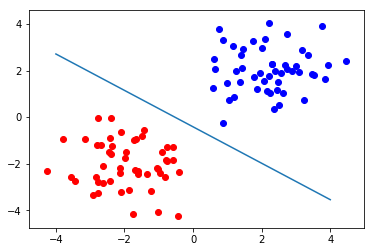

In [314]:
# Plot a line y = -x
x_axis = np.linspace(-4, 4, 100)
y_axis = -W_value[0][0]/W_value[1][0] * x_axis - b_value[0]/W_value[1][0]
plt.plot(x_axis, y_axis)

# Add the red and blue points
plt.scatter(red_points[:,0], red_points[:,1], color='red')
plt.scatter(blue_points[:,0], blue_points[:,1], color='blue')
plt.show()

# Multi-layer perceptrons

## Motivation

So now we are able to train linear classifiers of arbitrary dimensionality automatically. However, many real-world classes are not linearly separable. This means that there does not exist any line with all the points of the first class on one side of the line and all the points of the other class on the other side. Let's illustrate this with an example.

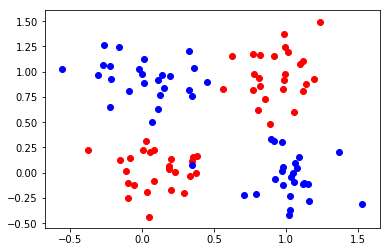

In [315]:
# Create two clusters of red points centered at (0, 0) and (1, 1), respectively.
red_points = np.concatenate((
    0.2*np.random.randn(25, 2) + np.array([[0, 0]]*25),
    0.2*np.random.randn(25, 2) + np.array([[1, 1]]*25)
))

# Create two clusters of blue points centered at (0, 1) and (1, 0), respectively.
blue_points = np.concatenate((
    0.2*np.random.randn(25, 2) + np.array([[0, 1]]*25),
    0.2*np.random.randn(25, 2) + np.array([[1, 0]]*25)
))

# Plot them
plt.scatter(red_points[:,0], red_points[:,1], color='red')
plt.scatter(blue_points[:,0], blue_points[:,1], color='blue')
plt.show()

As we can see, it is impossible to draw a line that separates the blue points from the red points. Instead, our decision boundary has to have a rather complex shape. This is where multi-layer perceptrons come into play: They allow us to train a decision boundary of a more complex shape than a straight line.

## Computational graph

As their name suggests, multi-layer perceptrons (MLPs) are composed of multiple perceptrons stacked one after the other in a layer-wise fashion. Let's look at a visualization of the computational graph:

<img src="https://github.com/johnsl01/WebBits/blob/master/Tensorflow/mlp.png?2&raw=1">

As we can see, the input is fed into the first layer, which is a multidimensional perceptron with a weight matrix $W_1$ and bias vector $b_1$. The output of that layer is then fed into second layer, which is again a perceptron with another weight matrix $W_2$ and bias vector $b_2$. This process continues for every of the $L$ layers until we reach the output layer. We refer to the last layer as the <b>output layer</b> and to every other layer as a <b>hidden layer</b>.

an MLP with one hidden layers computes the function

$$\sigma(\sigma(X \, W_1 + b_1) W_2 + b_2) \,,$$

an MLP with two hidden layers computes the function

$$\sigma(\sigma(\sigma(X \, W_1 + b_1) W_2 + b_2) \, W_3 \,,$$

and, generally, an MLP with $L-1$ hidden layers computes the function

$$\sigma(\sigma( \cdots \sigma(\sigma(X \, W_1 + b_1) W_2 + b_2) \cdots) \, W_L + b_L) \,.$$

## Implementation

Using the library we have built, we can now easily implement multi-layer perceptrons without further work.

In [316]:
# Create a new graph
Graph().as_default()

# Create training input placeholder
X = placeholder()

# Create placeholder for the training classes
c = placeholder()

# Build a hidden layer
W_hidden = Variable(np.random.randn(2, 2))
b_hidden = Variable(np.random.randn(2))
p_hidden = sigmoid( add(matmul(X, W_hidden), b_hidden) )

# Build the output layer
W_output = Variable(np.random.randn(2, 2))
b_output = Variable(np.random.randn(2))
p_output = softmax( add(matmul(p_hidden, W_output), b_output) )

# Build cross-entropy loss
J = negative(reduce_sum(reduce_sum(multiply(c, log(p_output)), axis=1)))

# Build minimization op
minimization_op = GradientDescentOptimizer(learning_rate = 0.03).minimize(J)

# Build placeholder inputs
feed_dict = {
    X: np.concatenate((blue_points, red_points)),
    c:
        [[1, 0]] * len(blue_points)
        + [[0, 1]] * len(red_points)
    
}

# Create session
session = Session()

# Perform 100 gradient descent steps
for step in range(10000):
    J_value = session.run(J, feed_dict)
    if step % 100 == 0:
        print("Step:", step, " Loss:", J_value)
    session.run(minimization_op, feed_dict)

# Print final result
W_hidden_value = session.run(W_hidden)
print("Hidden layer weight matrix:\n", W_hidden_value)
b_hidden_value = session.run(b_hidden)
print("Hidden layer bias:\n", b_hidden_value)
W_output_value = session.run(W_output)
print("Output layer weight matrix:\n", W_output_value)
b_output_value = session.run(b_output)
print("Output layer bias:\n", b_output_value)

Step: 0  Loss: 90.6886432279835
Step: 100  Loss: 68.48772648972235
Step: 200  Loss: 40.17227440763328
Step: 300  Loss: 15.894264043985947
Step: 400  Loss: 14.874418062238979
Step: 500  Loss: 14.650787205610111
Step: 600  Loss: 14.557780516800284
Step: 700  Loss: 14.501090209811224
Step: 800  Loss: 14.45886247522656
Step: 900  Loss: 14.424025138462389
Step: 1000  Loss: 14.393584088053522
Step: 1100  Loss: 14.366002934979551
Step: 1200  Loss: 14.340390021164962
Step: 1300  Loss: 14.316185768673028
Step: 1400  Loss: 14.293020153823528
Step: 1500  Loss: 14.270639477185673
Step: 1600  Loss: 14.248865480471524
Step: 1700  Loss: 14.227571065100484
Step: 1800  Loss: 14.20666512134664
Step: 1900  Loss: 14.186082616416153
Step: 2000  Loss: 14.165777846278708
Step: 2100  Loss: 14.145719661676823
Step: 2200  Loss: 14.125887969761273
Step: 2300  Loss: 14.106271089777648
Step: 2400  Loss: 14.086863702374716
Step: 2500  Loss: 14.067665228068591
Step: 2600  Loss: 14.048678528479854
Step: 2700  Loss: 1

Let's now visualize the decision boundary:

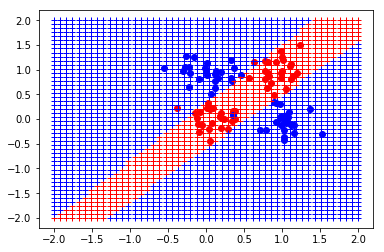

In [317]:
# Visualize classification boundary
xs = np.linspace(-2, 2)
ys = np.linspace(-2, 2)
pred_classes = []
for x in xs:
    for y in ys:
        pred_class = session.run(p_output,
                              feed_dict={X: [[x, y]]})[0]
        pred_classes.append((x, y, pred_class.argmax()))
xs_p, ys_p = [], []
xs_n, ys_n = [], []
for x, y, c in pred_classes:
    if c == 0:
        xs_n.append(x)
        ys_n.append(y)
    else:
        xs_p.append(x)
        ys_p.append(y)
plt.scatter(red_points[:,0], red_points[:,1], color='red')
plt.scatter(blue_points[:,0], blue_points[:,1], color='blue')
plt.plot(xs_p, ys_p, 'r+', xs_n, ys_n, 'b+')
plt.show()

As we can see, we have learned a rather complex decision boundary. If we use more layers, the decision boundary can become arbitrarily complex, allowing us to learn classification patterns that are impossible to spot by a human being, especially in higher dimensions.

# Recap

Congratulations on making it this far! You have learned the foundations of building neural networks from scratch, and in contrast to most machine learning practitioners, you now know how it all works under the hood and why it is done the way it is done.

Let's recap what we have learned. We started out by considering <b>computational graphs</b> in general, and we saw how to build them and how to compute their output. We then moved on to describe <b>perceptrons</b>, which are linear classifiers that assign a probability to each output class by squashing the output of $w^Tx+b$ through a <b>sigmoid</b> (or <b>softmax</b>, in the case of multiple classes). Following that, we saw how to judge how good a classifier is - via a loss function, the <b>cross-entropy loss</b>, the minimization of which is equivalent to <b>maximum likelihood</b>. In the next step, we saw how to minimize the loss via <b>gradient descent</b>: By iteratively stepping into the direction of the negative gradient. We then introduced <b>backpropagation</b> as a means of computing the derivative of the loss with respect to each node by performing a breadth-first search and multiplying according to the chain rule. We used all that we've learned to train a good linear classifier for the red/blue example dataset. Finally, we learned about <b>multi-layer perceptrons</b> as a means of learning non-linear decision boundaries, implemented an MLP with one hidden layer and successfully trained it on a non-linearly-separable dataset.

# Next steps

You now know all the fundamentals for training arbitrary neural networks. As a next step, you should learn about the following topics (Google is your friend):
- The difference between training loss and test loss
- Overfitting and underfitting
- Regularization and early stopping
- Dropout
- Convolutional neural networks
- Recurrent neural networks
- Autoencoders
- Deep Generative Models

All of these topics are dealt with in the book "Deep Learning" by Ian Goodfellow, Yoshua Bengio and Aaron Courville, which I highly recommend everyone to read. A free online version of the book can be found at http://www.deeplearningbook.org/.

In [0]:
#@title
